In [1]:
!pip install jcopdl==1.1.9

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16924 sha256=e2a61e656f5503c40769b327b7364b8e3f9672a3e06cf6a93ddbf1b0becce5e2
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import dataset, dataloader
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import scipy.io as io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

PART - 1

In [3]:
class CNN(nn.Module):
  def __init__(self, in_features):
    super().__init__()

    self.block1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (5,5)), 
                                torch.nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=2), 
                                nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (2,2)),
                                torch.nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=1),
                                nn.Flatten(start_dim = 0, end_dim = -1)
                                )
    
    self.block2 = nn.Sequential(nn.Linear(in_features = in_features, out_features= 50),
                                nn.Linear(in_features = 50, out_features = 10),
                                )
    
    self.Softmax = nn.Softmax(dim = 0)
                               
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)

    return self.Softmax(x)

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
data_set  = datasets.MNIST(train = True, download = True, root = "./data", transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
data_set  = datasets.MNIST(train = True, download = True, root = "./data", transform = transforms.ToTensor())
dataset_indices = list(range(len(data_set)))
indices = np.random.shuffle(dataset_indices)
train_idx, val_idx = dataset_indices[int(np.floor(0.2 * len(data_set))):], dataset_indices[:int(np.floor(0.2 * len(data_set)))]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_load = DataLoader(data_set, 64, sampler = train_sampler)
val_load = DataLoader(data_set, 64,  sampler = val_sampler)

In [7]:
data_set.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

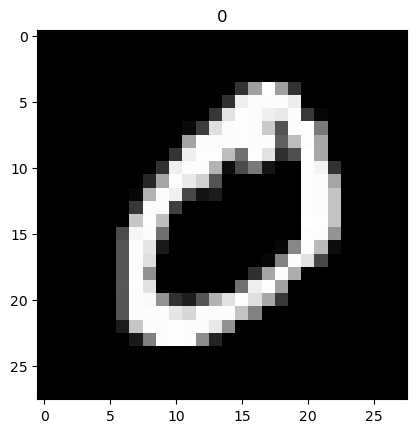

In [8]:
sample = 1
image = data_set[sample]
fig = plt.figure
plt.imshow(image[0][0], cmap='gray')
plt.title(image[1])
plt.show()


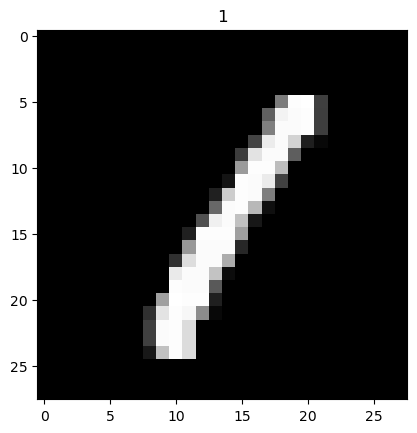

In [9]:
sample = 3
image = data_set[sample]
fig = plt.figure
plt.imshow(image[0][0], cmap='gray')
plt.title(image[1])
plt.show()


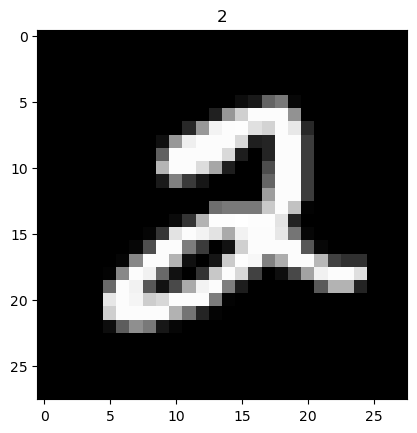

In [10]:
sample = 5
image = data_set[sample]
fig = plt.figure
plt.imshow(image[0][0], cmap='gray')
plt.title(image[1])
plt.show()


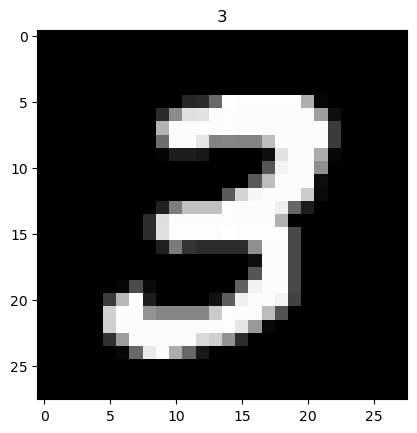

In [11]:
sample = 7
image = data_set[sample]
fig = plt.figure
plt.imshow(image[0][0], cmap='gray')
plt.title(image[1])
plt.show()

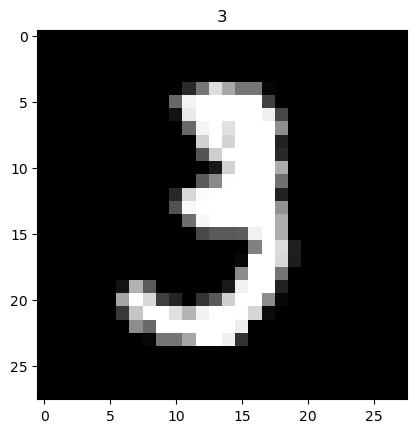

In [12]:
sample = 10
image = data_set[sample]
fig = plt.figure
plt.imshow(image[0][0], cmap='gray')
plt.title(image[1])
plt.show()

In [13]:
# train_load = DataLoader(train_set, 64, shuffle = True)
# test_load = DataLoader(test_set, 64, shuffle = True)

In [26]:
import torch.optim as optim
from tqdm.auto import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN(2000).to(device)

optimizer = optim.Adam(model.parameters(), lr = 10e-5)
loss_fn = nn.CrossEntropyLoss().to(device)


def train(model, dataloader, test_dataloader, device = "cpu", epochs = 50, trans = False, trans_test = False):
  epoch = []
  accuracy = []
  cost = []
  validation_accuracy = []
  validation_loss = []
  for i in range(epochs):
      epoch.append(i)

      costs = 0
      correct = 0
    
      for ins, outs in tqdm(dataloader, desc= "train"):
        if trans:
          ins = trans(ins)
        ins = ins.to(device)
        outs = outs.to(device)
        loss_in = torch.zeros(len(ins), 10).to(device)

        for val in range(len(ins)):
          loss_in[val][outs[val]] = 1
        preds = []

        for j in range(len(ins)):
          preds.append(model(ins[j]))

        preds = torch.stack(preds, dim = -2).to(device)
        loss = loss_fn(preds, loss_in)

        if "train":
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        costs += loss.item() * ins.shape[0]
        correct += (preds.argmax(1) == outs).sum().item()

      costs = costs / len(dataloader)
      correct = correct / len(dataloader)
      accuracy.append(correct)
      cost.append(costs)
      print("training cost in epoch: ", f"{i} ", costs)
      print("training accuracy in epoch: ", f"{i} ", correct)
      
      for ins, outs in tqdm(test_dataloader, desc= "test"):
        if trans_test:
            ins = trans_test(ins)
        ins = ins.to(device)
        outs = outs.to(device)
        loss_in = torch.zeros(len(ins), 10).to(device)

        for val in range(len(ins)):
          loss_in[val][outs[val]] = 1

        preds = []
        for j in range(len(ins)):
          preds.append(model(ins[j]))

        preds = torch.stack(preds, dim = -2).to(device)
        loss = loss_fn(preds, loss_in)

        costs += loss.item() * ins.shape[0]
        correct += (preds.argmax(1) == outs).sum().item()

      costs = costs / len(test_dataloader)
      correct = correct / len(test_dataloader)
      validation_accuracy.append(correct)
      validation_loss.append(costs)
      print("validation_cost in epoch: ", f"{i} ", costs)
      print("validation_accuracy in epoch: ", f"{i} ", correct)

  plt.plot(epoch, accuracy)
  plt.plot(epoch, cost)
  plt.plot(epoch, validation_accuracy)
  plt.plot(epoch, validation_loss)
  plt.legend(['train_acc', 'train_loss', 'val_acc', 'val_loss'])
  plt.xlabel("epochs")
  plt.title('accuracy and loss plots')

  plt.show()
  #epoch, cost, accuracy
  return 
        
def plot(epochs, costs, accuracy):

  plt.plot(epochs, costs)
  plt.plot(epochs, accuracy)

  plt.xlabel("epochs")
  plt.title('accuracy and loss plots')

  plt.show()

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  118.78285252888998
training accuracy in epoch:  0  40.88666666666666


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  109.98472021170542
validation_accuracy in epoch:  0  48.600460992907806


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  109.1341455078125
training accuracy in epoch:  1  48.74666666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  108.69474361176188
validation_accuracy in epoch:  1  49.45078014184397


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  108.0696896870931
training accuracy in epoch:  2  49.62133333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  104.81689637231489
validation_accuracy in epoch:  2  53.721390070921984


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  103.23162592569987
training accuracy in epoch:  3  54.672


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  103.09905582482087
validation_accuracy in epoch:  3  55.05144680851064


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  102.3474262898763
training accuracy in epoch:  4  55.382666666666665


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  102.31459470946399
validation_accuracy in epoch:  4  55.863737588652484


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  101.89112006632487
training accuracy in epoch:  5  55.82533333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  101.96886748006834
validation_accuracy in epoch:  5  56.18524113475178


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  99.18616008504232
training accuracy in epoch:  6  58.708


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  96.80445080106479
validation_accuracy in epoch:  6  61.67929787234043


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  96.12342803955079
training accuracy in epoch:  7  61.80133333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  96.197166380375
validation_accuracy in epoch:  7  62.052134751773046


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  95.81517443847656
training accuracy in epoch:  8  62.016


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  96.05776168109001
validation_accuracy in epoch:  8  62.14370212765957


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  95.62139147949219
training accuracy in epoch:  9  62.165333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  95.88036127390761
validation_accuracy in epoch:  9  62.29875177304965


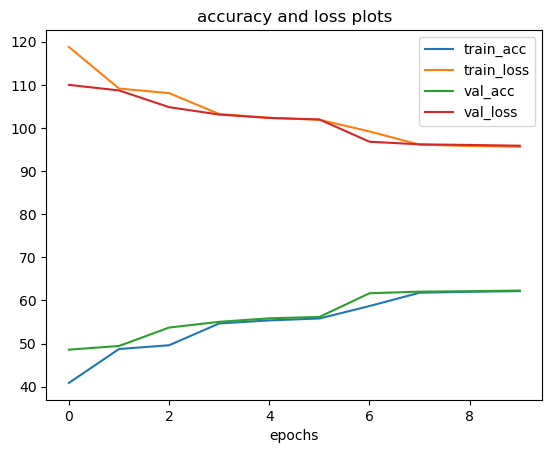

In [15]:
train(model, train_load, val_load,  device, epochs = 10)

torch.save(model, "CNN_normal.pt")

**Analysis:**
The accuracy of this neural network is 62.61% in the final epoch. The learning rate is set at 10e-5. The model moves towards convergence progressively after each epoch as seen in the plots.  

In [16]:
class CNN_residual(nn.Module):
  def __init__(self, features):
    super().__init__()

    self.block1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = (5,5)), 
                                torch.nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=2)
                                )
    
    self.block2 = nn.Sequential(nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = (2,2)),
                                torch.nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=1))
    
    self.pooling = nn.MaxPool2d(kernel_size=3, stride=1)
    
    self.flatten = nn.Flatten(start_dim = 0, end_dim = -1)
    
    self.block3 = nn.Sequential(nn.Linear(in_features = features,  out_features= 50),
                                nn.Linear(in_features = 50, out_features = 10),
                                )
    
    self.Softmax = nn.Softmax(dim = 0)
                               
  def forward(self, x):
    x = self.block1(x)
    temp = self.pooling(x)
    x = self.block2(x) + temp
    x = self.flatten(x)
    x = self.block3(x)

    return self.Softmax(x)

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  105.15528454589844
training accuracy in epoch:  0  52.528


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  96.95572025039347
validation_accuracy in epoch:  0  61.098553191489366


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  95.61804990641276
training accuracy in epoch:  1  61.962666666666664


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  95.36060177163199
validation_accuracy in epoch:  1  62.61682269503546


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  95.19349903361002
training accuracy in epoch:  2  62.370666666666665


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  95.16000566301277
validation_accuracy in epoch:  2  62.81580141843971


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  94.93186655680339
training accuracy in epoch:  3  62.589333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  95.16572120801776
validation_accuracy in epoch:  3  62.7797304964539


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  94.93475032552084
training accuracy in epoch:  4  62.602666666666664


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  95.0009303841557
validation_accuracy in epoch:  4  62.97660992907801


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  94.76405897013346
training accuracy in epoch:  5  62.77466666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  94.88296848610952
validation_accuracy in epoch:  5  63.07326950354609


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  94.70829251098633
training accuracy in epoch:  6  62.809333333333335


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  94.86491900569834
validation_accuracy in epoch:  6  63.0787730496454


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  94.64449028523764
training accuracy in epoch:  7  62.872


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  94.92969093447205
validation_accuracy in epoch:  7  63.02591489361702


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  94.60363780721029
training accuracy in epoch:  8  62.91466666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  94.73297204422104
validation_accuracy in epoch:  8  63.20699290780142


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  94.55725713094076
training accuracy in epoch:  9  62.961333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  94.97075394596612
validation_accuracy in epoch:  9  62.94128368794326


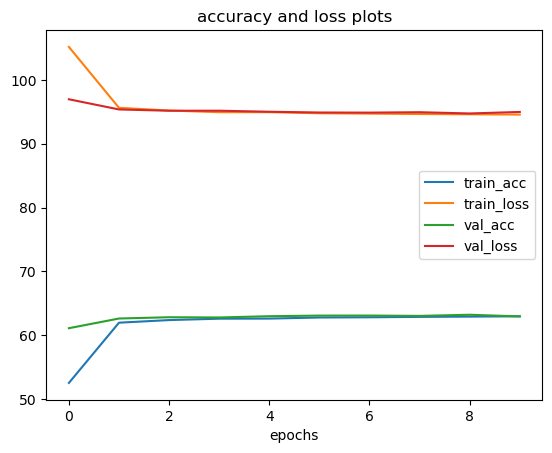

In [17]:
import torch.optim as optim
from tqdm.auto import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_residual(2000).to(device)
# callback = Callback(model, config, early_stop_patience = 5, outdir="model")

optimizer = optim.Adam(model.parameters(), lr = 10e-4)
loss_fn = nn.CrossEntropyLoss().to(device)

train(model, train_load, val_load, device, epochs = 10)
torch.save(model, "CNN_residual.pt")

Analysis:

The residual connection shows a minor improvement of 1% in the neural network. The accuracy of this modification is 62.61% in the final epoch. The learning rate is set at 10e-4. The model moves towards convergence progressively and faster than the typical CNN model.

PART - 2

In [29]:
train_transform1 = transforms.Compose([
    transforms.RandomRotation(15)
])

train_transform2 = transforms.Compose([
     transforms.RandomHorizontalFlip(0.5)
])
train_transform3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2))
])

train_transform4 = transforms.Compose([
    transforms.RandomRotation(15)
])

train_transform4 = transforms.Compose([
    transforms.Resize((224,224))
])

train_transform5 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.Resize((224,224))
])

trans_test = transforms.Compose([
    transforms.Resize((224,224))
])

In [19]:
data_set  = datasets.MNIST(train = True, download = True, root = "./data", transform = transforms.ToTensor())
dataset_indices = list(range(len(data_set)))
indices = np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * len(data_set)))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [20]:
train_load = DataLoader(data_set, 64, sampler = train_sampler)
val_load = DataLoader(data_set, 64,  sampler = val_sampler)

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  119.85673192342122
training accuracy in epoch:  0  39.602666666666664


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  105.7585435245054
validation_accuracy in epoch:  0  53.418099290780134


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  104.90165756225586
training accuracy in epoch:  1  53.47866666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  103.26476093292236
validation_accuracy in epoch:  1  55.16743971631205


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  100.44461482747396
training accuracy in epoch:  2  57.872


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  97.45601262659383
validation_accuracy in epoch:  2  61.07378723404255


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  97.51361690266927
training accuracy in epoch:  3  60.589333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  96.55471963252074
validation_accuracy in epoch:  3  61.8329219858156


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  96.86364275105794
training accuracy in epoch:  4  61.084


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  96.15534968610181
validation_accuracy in epoch:  4  62.14406382978723


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  96.49452241007486
training accuracy in epoch:  5  61.38933333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  95.92431726014698
validation_accuracy in epoch:  5  62.32121985815603


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  96.15615897623698
training accuracy in epoch:  6  61.665333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  95.88848116324132
validation_accuracy in epoch:  6  62.26417730496454


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  95.95760815429688
training accuracy in epoch:  7  61.83866666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  95.64231175020909
validation_accuracy in epoch:  7  62.47786524822695


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  95.83244459025065
training accuracy in epoch:  8  61.924


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  95.48221477254232
validation_accuracy in epoch:  8  62.60597872340425


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  95.76245561726888
training accuracy in epoch:  9  61.961333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  95.37871801427745
validation_accuracy in epoch:  9  62.69660283687943


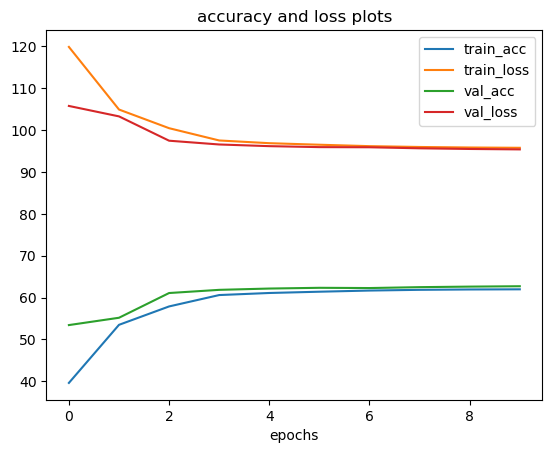

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_residual(2000).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 10e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
train(model, train_load, val_load, device, epochs = 10, trans = train_transform1)
torch.save(model, "CNN_transformed1.pt")

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  125.42452080281575
training accuracy in epoch:  0  33.37733333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  120.96441397933418
validation_accuracy in epoch:  0  37.10839007092199


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  120.01916522216797
training accuracy in epoch:  1  37.548


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  119.99324940717982
validation_accuracy in epoch:  1  37.88057446808511


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  119.56605114746094
training accuracy in epoch:  2  37.86666666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  119.658695097416
validation_accuracy in epoch:  2  38.1854609929078


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  119.02902028401692
training accuracy in epoch:  3  38.40533333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  117.35631878819026
validation_accuracy in epoch:  3  40.773432624113475


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  115.82421924845377
training accuracy in epoch:  4  41.85066666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  111.97688443875144
validation_accuracy in epoch:  4  46.50452482269504


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  110.91694991048178
training accuracy in epoch:  5  46.89066666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  110.66542773383391
validation_accuracy in epoch:  5  47.361120567375885


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  110.33892669677735
training accuracy in epoch:  6  47.344


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  110.87985017654745
validation_accuracy in epoch:  6  47.19863829787234


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  110.03596383666992
training accuracy in epoch:  7  47.604


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  110.36202647237576
validation_accuracy in epoch:  7  47.70002127659574


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  109.78689153035482
training accuracy in epoch:  8  47.82666666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  110.09054003154132
validation_accuracy in epoch:  8  47.860780141843975


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  109.59374003092448
training accuracy in epoch:  9  48.008


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  109.70387327694725
validation_accuracy in epoch:  9  48.34046808510638


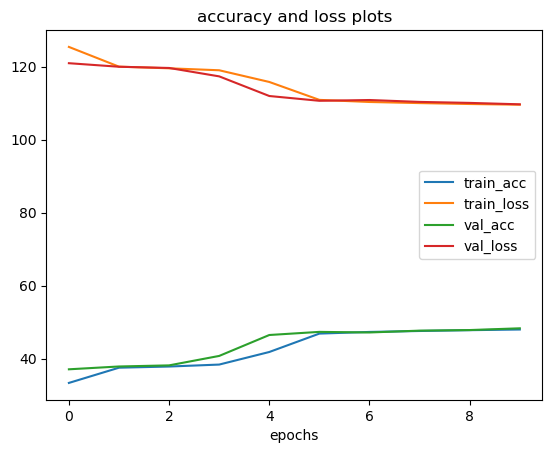

In [22]:
model = CNN_residual(2000).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 10e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
train(model, train_load, val_load, device, epochs = 10, trans = train_transform2)
torch.save(model, "CNN_transformed2.pt")

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  119.19075990804036
training accuracy in epoch:  0  40.23466666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  109.9347715492519
validation_accuracy in epoch:  0  48.703375886524825


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  101.58702869669597
training accuracy in epoch:  1  57.025333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  97.9714003228262
validation_accuracy in epoch:  1  60.76609219858156


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  96.95437444051107
training accuracy in epoch:  2  61.14933333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  96.74206700291192
validation_accuracy in epoch:  2  61.6497304964539


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  96.2276355489095
training accuracy in epoch:  3  61.67466666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  96.23163546487794
validation_accuracy in epoch:  3  62.01954609929078


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  95.81002406819661
training accuracy in epoch:  4  62.037333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  96.0167675616758
validation_accuracy in epoch:  4  62.15445390070922


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  95.55517364501954
training accuracy in epoch:  5  62.230666666666664


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  95.81877273072588
validation_accuracy in epoch:  5  62.35229078014184


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  95.36935165405274
training accuracy in epoch:  6  62.38133333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  95.76264047257443
validation_accuracy in epoch:  6  62.31585815602837


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  95.23773472086589
training accuracy in epoch:  7  62.484


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  95.63110580303653
validation_accuracy in epoch:  7  62.47065957446809


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  95.13673225911458
training accuracy in epoch:  8  62.550666666666665


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  95.38986554128228
validation_accuracy in epoch:  8  62.72633333333333


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  95.02944250488281
training accuracy in epoch:  9  62.668


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  95.66960422386008
validation_accuracy in epoch:  9  62.48227659574468


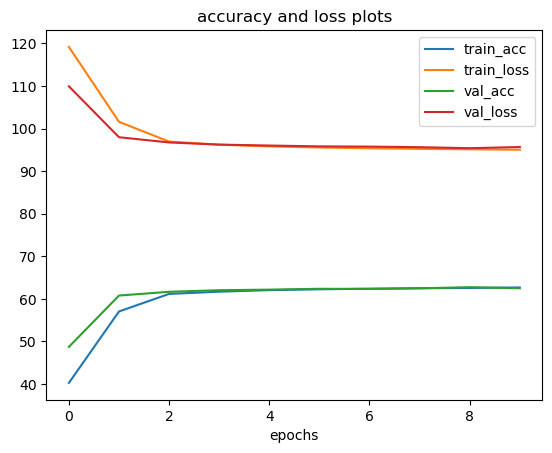

In [23]:
model = CNN_residual(2000).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 10e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
train(model, train_load, val_load, device, epochs = 10 , trans = train_transform3)
torch.save(model, "CNN_transformed3.pt")

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  138.5021553446452
training accuracy in epoch:  0  18.766666666666666


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  138.70592902590704
validation_accuracy in epoch:  0  19.1104609929078


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  138.3230498453776
training accuracy in epoch:  1  19.08


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  138.70958465370558
validation_accuracy in epoch:  1  19.16


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  130.33495952351888
training accuracy in epoch:  2  27.092


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  127.54910941082028
validation_accuracy in epoch:  2  30.303680851063834


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  124.78406099446615
training accuracy in epoch:  3  32.654666666666664


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  121.7480744480647
validation_accuracy in epoch:  3  36.12050354609929


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  121.02775765991211
training accuracy in epoch:  4  36.436


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  121.28570086913413
validation_accuracy in epoch:  4  36.58210638297872


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  120.62736422729492
training accuracy in epoch:  5  36.83733333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  121.15608817502284
validation_accuracy in epoch:  5  36.711900709219854


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  120.6308821105957
training accuracy in epoch:  6  36.84


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  121.18425494985378
validation_accuracy in epoch:  6  36.68531914893617


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  120.52685025024414
training accuracy in epoch:  7  36.94533333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  121.32647079370376
validation_accuracy in epoch:  7  36.584815602836876


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  120.365904296875
training accuracy in epoch:  8  37.11866666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  121.34503175078048
validation_accuracy in epoch:  8  36.564460992907804


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  120.37751397705078
training accuracy in epoch:  9  37.092


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  121.02533086866013
validation_accuracy in epoch:  9  36.862191489361706


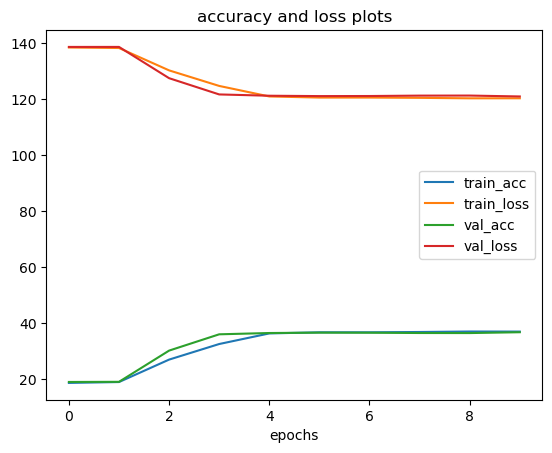

In [30]:
model = CNN_residual(233280).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 10e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
train(model, train_load, val_load, device, epochs = 10 , trans = train_transform4, trans_test = trans_test)
torch.save(model, "CNN_transformed4.pt")

train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  0  119.795998433431
training accuracy in epoch:  0  39.64533333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  0  112.87659324916541
validation_accuracy in epoch:  0  45.84385815602837


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  1  113.16251554361979
training accuracy in epoch:  1  44.86533333333333


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  1  111.65907714670601
validation_accuracy in epoch:  1  46.515241134751776


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  2  112.67155580647787
training accuracy in epoch:  2  45.089333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  2  110.85152500893884
validation_accuracy in epoch:  2  47.22919858156028


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  3  112.19865764363607
training accuracy in epoch:  3  45.48266666666667


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  3  110.71366949100359
validation_accuracy in epoch:  3  47.28448226950355


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  4  111.90856736246745
training accuracy in epoch:  4  45.717333333333336


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  4  110.85495265966105
validation_accuracy in epoch:  4  47.10487943262412


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  5  111.79930028279622
training accuracy in epoch:  5  45.742666666666665


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  5  110.72371027872073
validation_accuracy in epoch:  5  47.349695035461


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  6  111.70686634318034
training accuracy in epoch:  6  45.864


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  6  110.59335553941658
validation_accuracy in epoch:  6  47.29714893617021


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  7  111.74920463053385
training accuracy in epoch:  7  45.752


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  7  110.78827595200775
validation_accuracy in epoch:  7  47.190170212765956


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  8  111.61705908203125
training accuracy in epoch:  8  45.888


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  8  110.40024092524104
validation_accuracy in epoch:  8  47.51004255319148


train:   0%|          | 0/750 [00:00<?, ?it/s]

training cost in epoch:  9  111.58630732218424
training accuracy in epoch:  9  45.922666666666665


test:   0%|          | 0/188 [00:00<?, ?it/s]

validation_cost in epoch:  9  110.20549593472312
validation_accuracy in epoch:  9  47.69639716312056


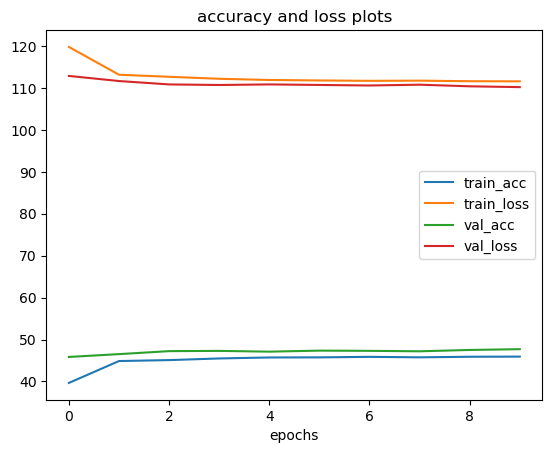

In [32]:
model = CNN_residual(233280).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 10e-6)
loss_fn = nn.CrossEntropyLoss().to(device)
train(model, train_load, val_load, device, epochs = 10 , trans = train_transform5, trans_test = trans_test)
torch.save(model, "CNN_transformed5.pt")

**Augmentation variation** Random rotation gives the best acuracy out of all the augmentations at 62.69% It is seen that reshape gives the worst accuracy and the model does not seem to converge at 10 epochs and needs more epochs. When applying all augmentations, accuracy is lower than a single rotation. It is probably because of extensive augmentation. The neural network finds it difficult to understand patterns with such a shallow network. The model is trained with AdamW and Adam optimizers with a learning rate of 10e-5 as well as 10e-6. 

**Following transformations have been used:** 
**reshape:** The transformation increases the size of image to 224x224 image that give a broader aspect of features
**random rotation:** randomly rotates image by 15 degrees
**random horizontal flip:** flips horizontally the image with 50% chance
**Gaussian Blur:** Adds gaussian blur as per kernel_size=(7, 13), sigma=(0.1, 0.2)



